In [56]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [57]:
import os
os.getcwd()

'/home/jay/Repos/ml/Deeplearning/Lecture3'

In [58]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/home/jay/.fastai/data/mnist_sample/train'),Path('/home/jay/.fastai/data/mnist_sample/labels.csv'),Path('/home/jay/.fastai/data/mnist_sample/valid')]

In [59]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
(path/'train').ls()

(#2) [Path('/home/jay/.fastai/data/mnist_sample/train/3'),Path('/home/jay/.fastai/data/mnist_sample/train/7')]

In [60]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

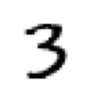

In [61]:
show_image(three_tensors[1]);

In [62]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

# Testing with averaging all test images

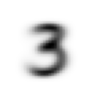

In [63]:
# takes mean over axis 0 -> 6131
mean3 = stacked_threes.mean(0)
show_image(mean3);

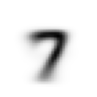

In [64]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

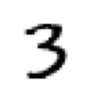

In [65]:
s_3 = stacked_threes[1]
show_image(s_3);

In [66]:
# using of values works
F.mse_loss(s_3.float(), mean7).sqrt(), F.mse_loss(s_3.float(), mean3).sqrt()

(tensor(0.3021), tensor(0.2021))

In [67]:

valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [68]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

In [69]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [70]:
is_3(s_3)

tensor(True)

In [71]:
is_3(valid_3_tens)

tensor([False,  True,  True,  ...,  True,  True, False])

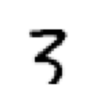

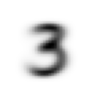

In [72]:
show_image(valid_3_tens[0]);
show_image(mean3);

In [73]:
accuracy_3s = is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

# Neural Net Model

In [74]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape, len(stacked_threes) + len(stacked_sevens)

(torch.Size([12396, 784]), 12396)

In [75]:

train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [76]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_x.shape

torch.Size([2038, 784])

In [82]:
valid_y = tensor([1]*valid_3_tens.shape[0] + [0]*valid_7_tens.shape[0]).unsqueeze(1)
valid_y.shape


torch.Size([2038, 1])

In [83]:
valid_dset = list(zip(valid_x, valid_y))

In [21]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [22]:
# requires_grad_ tracks the gradient w.r.t. the current variable being called
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [23]:
weights = init_params((28*28,1))
weights.shape

torch.Size([784, 1])

In [24]:
bias = init_params(1)

In [25]:
# prediction of the first image in the training set
(train_x[0]*weights.T).sum() + bias

tensor([-6.2330], grad_fn=<AddBackward0>)

In [26]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

In [28]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [29]:
# accuracy
corrects.float().mean().item()

0.5379961133003235

In [33]:
with torch.no_grad(): weights[0] *= 1.0001

In [34]:
# here there is no change in accuracy
# the loss function (accuracy) only changes if a prediction changes
# a small change in the weight does not change the prediction
# therefore gradient is close to 0
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5379961133003235

In [35]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()


In [36]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [85]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [88]:
batch = train_x[:4]
preds = linear1(batch)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        [-17.8700]], grad_fn=<AddBackward0>)

In [91]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(14.9071, grad_fn=<MeanBackward0>)

In [92]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [93]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [96]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.zero_()
bias.grad.zero_();
weights.grad.mean(),bias.grad

(tensor(0.), tensor([0.]))

In [97]:
def train_epoch(model, lr, params):
  for xb,yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad*lr
      p.grad.zero_()

In [98]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [99]:
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

In [100]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [102]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [103]:
validate_epoch(linear1)

0.9551

In [104]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.9536

In [105]:
for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.9536 0.9536 0.9536 0.9536 0.9536 0.9536 0.9536 0.9536 0.9536 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 

In [106]:
linear_model = nn.Linear(28*28,1)

In [107]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [108]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [109]:
opt = BasicOptim(linear_model.parameters(), lr)

In [110]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [111]:
validate_epoch(linear_model)

0.3388

In [112]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [114]:
train_model(linear_model, 20)

0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 0.9531 

In [115]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [116]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [121]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [122]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [123]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,76299560.000000,-1221219584.000000,0.948479,00:00
1,1085053118590222336.000000,-20888328390441959424.000000,0.961727,00:00
2,17923492880899767034798145536.000000,-367142460051953029782689546240.000000,0.962218,00:00
3,nan,nan,0.962218,00:00
4,nan,nan,0.504416,00:00
5,nan,nan,0.504416,00:00
6,nan,nan,0.504416,00:00
7,nan,nan,0.504416,00:00
8,nan,nan,0.504416,00:00
9,nan,nan,0.504416,00:00
